In [388]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris

In [389]:
df = load_iris()
df = pd.DataFrame(data= np.c_[df['data'], df['target']],
                     columns= df['feature_names'] + ['target'])
df = df[df['target'] != 2]
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,1.0
96,5.7,2.9,4.2,1.3,1.0
97,6.2,2.9,4.3,1.3,1.0
98,5.1,2.5,3.0,1.1,1.0


# Сигмоида
$\sigma=\frac{1}{1 + exp(-\left \langle w,x_{i} \right \rangle)}$

In [391]:
def sigmoid(wx):
    """Вычисляем сигмоиду для произведения векторов w и x"""
    return 1 / (1 + np.exp(-wx))

# Log Loss
$L(X) = -\sum^{l}_{i=1} (y_{i} \text{ln}(\sigma) + (1 - y_{i})\text{ln} (1-\sigma)).$


In [392]:
def log_loss(X, y, w):
    '''Вычисляет Log Loss для всего набора признаков X, таргетов y и весов w'''
    Sg = sigmoid(X@w)
    return -1 * np.sum(y * np.log(Sg) + (1 - y) * np.log(1 - Sg))

# Градиент
$$\frac{dL}{dw} = X^{T}(\sigma-Y)$$

In [393]:
def grad(X, y, w):
    '''Вычисляет градиент для для всего набора признаков X, таргетов y и весов w'''
    return X.T @ (sigmoid(X@w) - y)

# Градиентный спуск, предсказания и точность

In [394]:
def gd(X, y, w=None, eta = 0.01, iter=50, eps=1e-8):
    '''
    Реализует алгоритм градиентного спуска для Логистической регрессии.
    X - набор признаков, y - таргет
    w - Начальный набор весов. Если не задан - генерируется нулевой. Свободный член всегда генерируется.
    eta - шаг градиентного спуска. По умолчанию 0.01
    iter - количество итераций. По умолчанию 100
    eps - минимальное изменение вектора весов, при котором продолжается алгоритм спуска
    Возвращает кортеж из весов, где последний элемент - свободный член и значения ошибки
    '''
    # np.linalg.norm(point_1-point_2)
    losses = [] # Собираем ошибки для визуализации
    
    # Инициализируем веса.
    if w is None or w.shape[0] != y.shape[0]:
        w = np.zeros(X.shape[1])
    w = np.append(w, 0)
        
    # Добавляем столбец для свободного члена
    X = np.append(X, np.ones(X.shape[0]).reshape(-1, 1), axis=1)
    
    # Спускаемся
    for _ in range(iter):
        losses.append(log_loss(X, y, w))
        w_new = w - eta * grad(X, y, w)
        if np.linalg.norm(w_new - w) < eps:
            break
        w = w_new
    
    return w, losses

In [395]:
def predict(X, w):
    '''Предсказывает класс для набора признаков X с весами w'''
    X = np.append(X, np.ones(X.shape[0]).reshape(-1, 1), axis=1)

    return (sigmoid(X@w) > 0.5).astype('int')

In [396]:
def accuracy(X, y, w):
    '''Вычисляет точность для набора признаков X, таргетов y и весов w'''
    return np.sum((predict(X, w) == y).astype('int')) / y.shape[0]


# RMSProp

In [397]:
def rmsprop(X, y, w=None, eta = 0.1, gamma = 0.9, iter=50, eps=1e-8):
    '''
    Реализует алгоритм RMSProp для Логистической регрессии.
    X - набор признаков, y - таргет
    w - Начальный набор весов. Если не задан - генерируется нулевой. Свободный член всегда генерируется.
    eta - шаг градиентного спуска. По умолчанию 0.01
    gamma - затухание. По умолчанию 0.9
    iter - количество итераций. По умолчанию 100
    eps - минимальное изменение вектора весов, при котором продолжается алгоритм спуска
    Возвращает кортеж из весов, где последний элемент - свободный член и значения ошибки
    '''
    losses = [] # Собираем ошибки для визуализации
    
    # Инициализируем веса.
    if w is None or w.shape[0] != y.shape[0]:
        w = np.zeros(X.shape[1])
    w = np.append(w, 0)
        
    # Добавляем столбец для свободного члена
    X = np.append(X, np.ones(X.shape[0]).reshape(-1, 1), axis=1)
    
    # Спускаемся
    E = 0
    for _ in range(iter):
        losses.append(log_loss(X, y, w))
        g = grad(X, y, w)
        E = E * gamma + (1 - gamma) * g ** 2
        w_new = w - eta * g / np.sqrt(E + 1e-8)
        if np.linalg.norm(w_new - w) < eps:
            break
        w = w_new
    
    return w, losses

# Nadam

In [398]:
def nadam(X, y, w=None, eta = 0.1, mu = 0.95, nu = 0.95, iter=50, eps=1e-8):
    '''
    Реализует алгоритм RMSProp для Логистической регрессии.
    X - набор признаков, y - таргет
    w - Начальный набор весов. Если не задан - генерируется нулевой. Свободный член всегда генерируется.
    eta - шаг градиентного спуска. По умолчанию 0.1
    mu - затухание первого момента. По умолчанию 0.9
    nu - затухание второго момента. По умолчанию 0.95
    iter - количество итераций. По умолчанию 100
    eps - минимальное изменение вектора весов, при котором продолжается алгоритм спуска
    Возвращает кортеж из весов, где последний элемент - свободный член и значения ошибки
    '''
    losses = [] # Собираем ошибки для визуализации
    # Инициализируем веса.
    if w is None or w.shape[0] != y.shape[0]:
        w = np.zeros(X.shape[1])
    w = np.append(w, 0)
        
    # Добавляем столбец для свободного члена
    X = np.append(X, np.ones(X.shape[0]).reshape(-1, 1), axis=1)
    
    # Спускаемся
    m = 0
    n = 0
    for _ in range(iter):
        losses.append(log_loss(X, y, w))
        g = grad(X, y, w)
        m = mu * m + (1 - mu) * g
        n = nu * n + (1 - nu) * g ** 2 
        mhat = (mu * m / (1 - mu)) + ((1 - mu) * g / (1 - mu))
        nhat = nu * n / (1 - nu)
        w_new = w - eta / np.sqrt(nhat + 1e-8) * mhat
        if np.linalg.norm(w_new - w) < eps:
            break
        w = w_new
    
    return w, losses

# Исследования

In [399]:
X = df.drop('target', axis=1).to_numpy()
y = df['target'].to_numpy()
N = 100

In [400]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Градиентный спуск

In [401]:
w_gd, losses_gd = gd(X_train, y_train, iter=N)
accuracy_gd = accuracy(X_test, y_test, w_gd)
accuracy_gd, losses_gd[-1]

(1.0, 0.5004035716726947)

In [402]:
w_rms, losses_rms = rmsprop(X_train, y_train, iter=N)
accuracy_rms = accuracy(X_test, y_test, w_rms)
accuracy_rms, losses_rms[-1]

(1.0, 0.128574310036481)

In [403]:
w_nadam, losses_nadam = nadam(X_train, y_train, iter=N)
accuracy_nadam = accuracy(X_test, y_test, w_nadam)
accuracy_nadam, losses_nadam[-1]

(1.0, 0.00010583781850250287)

In [404]:
epoh = range(10, 100)

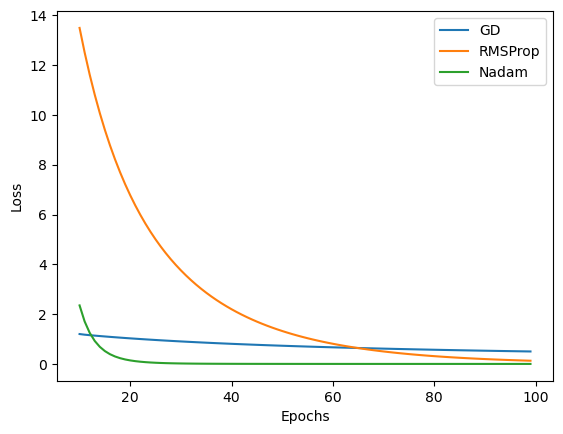

In [405]:
plt.plot(epoh, losses_gd[10:], label='GD')
plt.plot(epoh, losses_rms[10:], label='RMSProp')
plt.plot(epoh, losses_nadam[10:], label='Nadam')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Выводы
Они немного странные.

Все модели показали accuracy = 1. То ли данные хорошо разделены, то ли я ошибся.

Nadam показал лучшую функцию потерь и быстрее всех вышел на хороший результат.

RMSProp дольше чем GD выходил на хороший результат, но в итоге показал лучший результат по потерям, чм GD.

Все тесты проводил с рекомендованными значениями гиперпараметров.  